# Overview

**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# import custom functions
import sys
sys.path.append('/Users/dat/Library/CloudStorage/OneDrive-foryouandyourcustomers/GitHub/AutomatedPackagingCategories_Showcase/ml_packaging_classification/src')
import utils

In [3]:
SEED = 42

# Load data

In [4]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

## Clean data

In [5]:
df['material_number'] = df['material_number'].astype('object')

df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

df.info()

## Split data into train/test

In [8]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [9]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

# DecisionTree pipeline without oversampling

## DecisionTree (without HPO)

In [10]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.36161137440758295,
                                     1: 0.3272337383845604,
                                     2: 0.34813688212927757,
                                     3: 3.5598755832037323, 4: 1.308,
                                     5: 286.125, 6: 6.6347826086956525,
                                     7: 2.5043763676148796,
                                     8: 4.231053604436229, 9: 7.153125,
                                     10: 0.8227893601725378,
                                     11: 4.385057471264368, 12: 65.4,
                                     13: 0.7388637830858619,
                                     14: 9.69915254237288, 15: 19.075,
                                     16: 190.75, 17: 176.07692307692307,
                                     18: 1.5466216216216215,
                                     19: 5.899484536082475,
                                     20: 0.24481283422459893,
                                     21: 0.21127930588886837,
                                     22: 1.5029546946815495,
                                     23: 0.34488473708000605,
                                     24: 1.9186923721709974,
                                     25: 1.6756954612005857, 26: 57.225,
                                     27: 1.9090909090909092,
                                     28: 2.0220848056537104})

In [11]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7494577006507592


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.73      0.71      0.72      1582
   B02 Blister and Insert Card       0.72      0.70      0.71      1749
          C01 - Folding carton       0.70      0.65      0.68      1644
                 C02 Trap Card       0.69      0.70      0.70       161
         C03 Trap Folding Card       0.76      0.73      0.75       438
            C04 Book packaging       1.00      0.50      0.67         2
               C05 Tray Packer       0.56      0.74      0.64        86
                  C06 Skincard       0.83      0.83      0.83       229
C07 Cardb. Sleeve w - w/o Shr.       0.45      0.44      0.45       135
C08 - Cardboard hanger w/o bag       0.34      0.33      0.33        80
        C09 - Paperboard pouch       0.78      0.78      0.78       696
  C10 - Carton cover (Lid box)       0.57      0.45      0.50       130
 C11 - Carton tube with or w/o       0.60      0.33      0.43  

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DecisionTree HPO

### Performe HPO

In [12]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_rf_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            # 'min_samples_leaf': trial.suggest_int('min_samples_split', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_rf_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [13]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="rf_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=30,
    # timeout=600, 
    show_progress_bar=True
)

[I 2023-07-13 15:43:48,733] A new study created in memory with name: rf_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:49,244] Trial 0 finished with value: 0.6302607496542646 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:49,660] Trial 1 finished with value: 0.6139149068446308 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.
[I 2023-07-13 15:43:49,796] Trial 2 finished with value: 0.05818716063213107 and parameters: {'max_depth': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:49,997] Trial 3 finished with value: 0.07845621291308699 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.
[I 2023-07-13 15:43:50,191] Trial 4 finished with value: 0.10011555113980182 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:50,546] Trial 5 finished with value: 0.5394398500079484 and parameters: {'max_depth': 12, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6302607496542646.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:50,958] Trial 6 finished with value: 0.6324320004783313 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 6 with value: 0.6324320004783313.
[I 2023-07-13 15:43:51,131] Trial 7 finished with value: 0.3072222406003206 and parameters: {'max_depth': 8, 'criterion': 'gini'}. Best is trial 6 with value: 0.6324320004783313.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:51,344] Trial 8 finished with value: 0.48125489676538635 and parameters: {'max_depth': 12, 'criterion': 'gini'}. Best is trial 6 with value: 0.6324320004783313.
[I 2023-07-13 15:43:51,539] Trial 9 finished with value: 0.039140981648200096 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 6 with value: 0.6324320004783313.
[I 2023-07-13 15:43:51,801] Trial 10 finished with value: 0.6351599173571484 and parameters: {'max_depth': 40, 'criterion': 'gini'}. Best is trial 10 with value: 0.6351599173571484.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:52,073] Trial 11 finished with value: 0.6347537486233147 and parameters: {'max_depth': 40, 'criterion': 'gini'}. Best is trial 10 with value: 0.6351599173571484.
[I 2023-07-13 15:43:52,368] Trial 12 finished with value: 0.6336219684165718 and parameters: {'max_depth': 40, 'criterion': 'gini'}. Best is trial 10 with value: 0.6351599173571484.
[I 2023-07-13 15:43:52,649] Trial 13 finished with value: 0.6393339209412483 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:52,933] Trial 14 finished with value: 0.6263243970157265 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:53,221] Trial 15 finished with value: 0.6340365693154948 and parameters: {'max_depth': 60, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.
[I 2023-07-13 15:43:53,506] Trial 16 finished with value: 0.635740936460425 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:53,783] Trial 17 finished with value: 0.628939459110616 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.
[I 2023-07-13 15:43:54,056] Trial 18 finished with value: 0.6262439502458919 and parameters: {'max_depth': 36, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:54,372] Trial 19 finished with value: 0.5836601114884171 and parameters: {'max_depth': 16, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:54,676] Trial 20 finished with value: 0.6238315693366056 and parameters: {'max_depth': 80, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.
[I 2023-07-13 15:43:54,960] Trial 21 finished with value: 0.6172178403991814 and parameters: {'max_depth': 100, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:55,216] Trial 22 finished with value: 0.6382647499233991 and parameters: {'max_depth': 20, 'criterion': 'gini'}. Best is trial 13 with value: 0.6393339209412483.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:55,483] Trial 23 finished with value: 0.6458741841991549 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 23 with value: 0.6458741841991549.
[I 2023-07-13 15:43:55,737] Trial 24 finished with value: 0.6071977014759562 and parameters: {'max_depth': 20, 'criterion': 'gini'}. Best is trial 23 with value: 0.6458741841991549.
[I 2023-07-13 15:43:56,075] Trial 25 finished with value: 0.6510311243065768 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.6510311243065768.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:56,380] Trial 26 finished with value: 0.6338720253424428 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.6510311243065768.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:56,653] Trial 27 finished with value: 0.6222429186462922 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.6510311243065768.
[I 2023-07-13 15:43:56,923] Trial 28 finished with value: 0.6092876337328941 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.6510311243065768.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[I 2023-07-13 15:43:57,200] Trial 29 finished with value: 0.6144157771921532 and parameters: {'max_depth': 28, 'criterion': 'gini'}. Best is trial 25 with value: 0.6510311243065768.


In [14]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Performance:  0.6510311243065768
  Best trial: {'max_depth': 28, 'criterion': 'gini'}


### Analyse HPO
Auswertung Optuna study

In [15]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,state
0,0,0.630261,2023-07-13 15:43:48.794401,2023-07-13 15:43:49.244686,0 days 00:00:00.450285,entropy,50,COMPLETE
1,1,0.613915,2023-07-13 15:43:49.246758,2023-07-13 15:43:49.659835,0 days 00:00:00.413077,entropy,32,COMPLETE
2,2,0.058187,2023-07-13 15:43:49.661343,2023-07-13 15:43:49.796709,0 days 00:00:00.135366,entropy,2,COMPLETE
3,3,0.078456,2023-07-13 15:43:49.798515,2023-07-13 15:43:49.997106,0 days 00:00:00.198591,entropy,4,COMPLETE
4,4,0.100116,2023-07-13 15:43:49.998595,2023-07-13 15:43:50.191199,0 days 00:00:00.192604,entropy,4,COMPLETE


In [16]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [17]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [18]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [19]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [20]:
best_trial.params

{'max_depth': 28, 'criterion': 'gini'}

In [21]:
# Define best model

# best_params = best_trial.params
best_params = {
    'max_depth': 50,
    'criterion': 'entropy'
}

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [22]:
#
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

mean train performance: 1.0
mean test performance: 0.5660811478245639


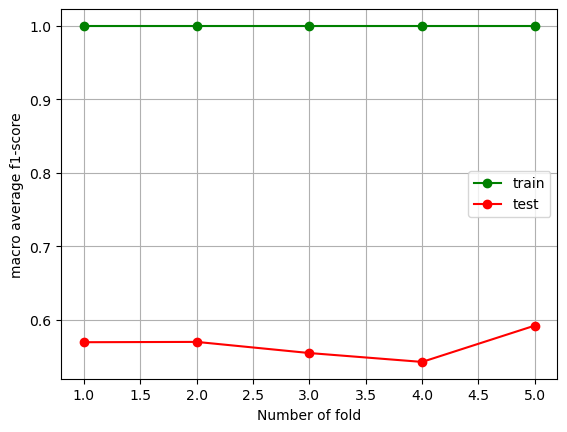

In [23]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='green', label='train')
plt.plot(folds, performance_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [24]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.73      0.64      0.68      1582
   B02 Blister and Insert Card       0.72      0.72      0.72      1749
          C01 - Folding carton       0.62      0.71      0.66      1644
                 C02 Trap Card       0.68      0.70      0.69       161
         C03 Trap Folding Card       0.67      0.67      0.67       438
            C04 Book packaging       0.00      0.00      0.00         2
               C05 Tray Packer       0.24      0.09      0.13        86
                  C06 Skincard       0.71      0.81      0.76       229
C07 Cardb. Sleeve w - w/o Shr.       0.44      0.47      0.46       135
C08 - Cardboard hanger w/o bag       0.28      0.26      0.27        80
        C09 - Paperboard pouch       0.68      0.74      0.71       696
  C10 - Carton cover (Lid box)       0.38      0.20      0.26       130
 C11 - Carton tube with or w/o       0.55      0.67      0.60  

### Deeper analysis of DecisionTreeClassifier

In [25]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,B02 Blister and Insert Card,B02 Blister and Insert Card,1.0
1,P06 – TightPack,P06 – TightPack,1.0
2,P10 - Shrink film and insert o,P10 - Shrink film and insert o,1.0
3,P07 Plastic Box,P07 Plastic Box,1.0
4,P04 Hanger/ Clip,P04 Hanger/ Clip,1.0
5,B02 Blister and Insert Card,B02 Blister and Insert Card,1.0
6,U0 – Unpacked,U0 – Unpacked,1.0
7,P06 – TightPack,P06 – TightPack,1.0
8,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0
9,P06 – TightPack,B01 - Blister and sealed blist,1.0


In [26]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test
7909,H1 Wooden box,P05 Plastic Pouch,1.0
14303,H1 Wooden box,P07 Plastic Box,1.0
15144,H1 Wooden box,F1 Fabric packaging,1.0


In [27]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)

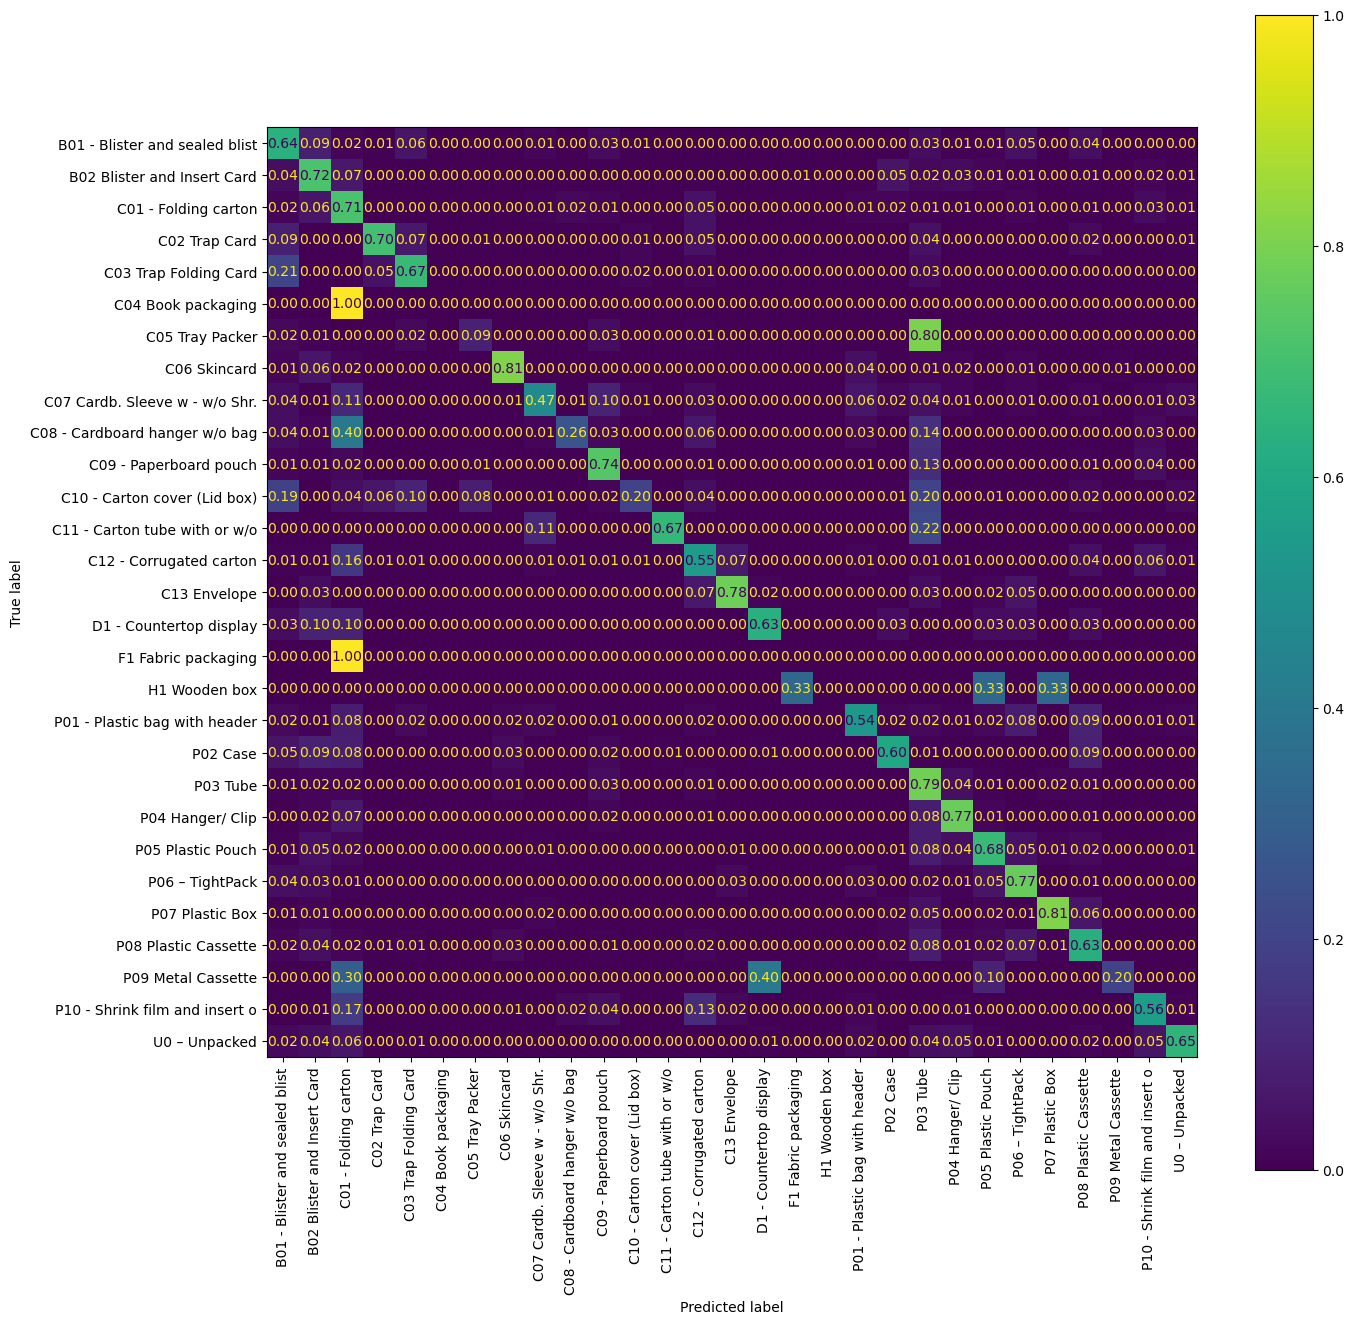

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

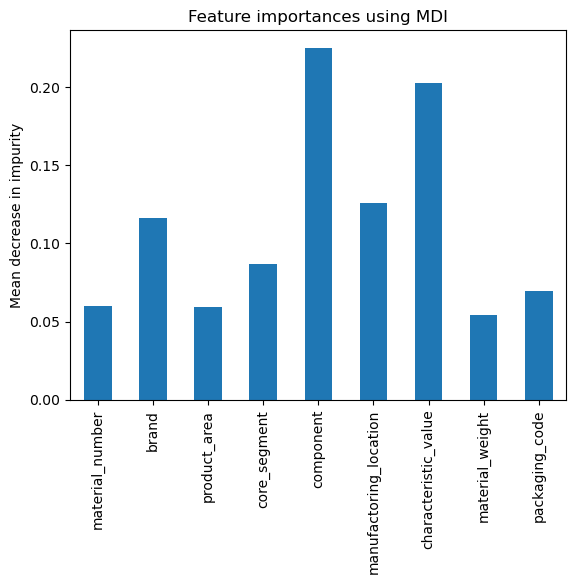

In [29]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# DecisionTree pipeline with oversampling

<Figure size 1000x500 with 0 Axes>

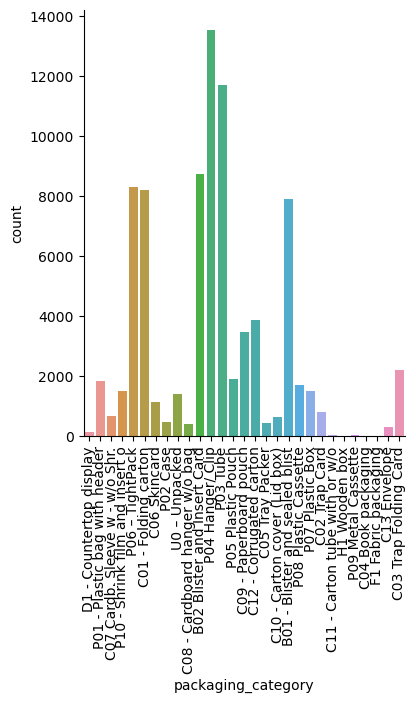

In [30]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

In [31]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'Metal Cassette': 100,
    'Carton tube with or w/o': 100,
    'Wooden box': 100,
    'Fabric packaging': 100,
    'Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)

distribution_classes = y.value_counts()
print('\n')
print('Class distribution after oversmapling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert Card': 8744, 'P06 – TightPack': 8296, 'C01 - Folding carton': 8219, 'B01 - Blister and sealed blist': 7912, 'C12 - Corrugated carton': 3872, 'C09 - Paperboard pouch': 3478, 'C03 Trap Folding Card': 2188, 'P05 Plastic Pouch': 1904, 'P01 - Plastic bag with header': 1850, 'P08 Plastic Cassette': 1708, 'P10 - Shrink film and insert o': 1499, 'P07 Plastic Box': 1491, 'U0 – Unpacked': 1415, 'C06 Skincard': 1143, 'C02 Trap Card': 804, 'C07 Cardb. Sleeve w - w/o Shr.': 676, 'C10 - Carton cover (Lid box)': 652, 'P02 Case': 485, 'C05 Tray Packer': 431, 'C08 - Cardboard hanger w/o bag': 400, 'C13 Envelope': 295, 'D1 - Countertop display': 150, 'P09 Metal Cassette': 50, 'C11 - Carton tube with or w/o': 44, 'H1 Wooden box': 16, 'F1 Fabric packaging': 15, 'C04 Book packaging': 10}


Class distribution after oversmapling
{'P04 Hanger/ Clip': 13543, 'P03 Tube': 11687, 'B02 Blister and Insert C

In [32]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

## DecisionTree (without HPO)

In [33]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_encoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.36320204826496705,
                                     1: 0.3286731902097557,
                                     2: 0.349668283728858,
                                     3: 3.5755349385960207,
                                     4: 1.3137536945812809,
                                     5: 28.738362068965518,
                                     6: 6.663968015992004,
                                     7: 2.5153927412661283,
                                     8: 4.249665370641851,
                                     9: 7.1845905172413795,
                                     10: 0.8264086863829049,
                                     11: 4.404346677236094,
                                     12: 28.738362068965518,
                                     13: 0.7421139333496583,
                                     14: 9.741817650496786,
                                     15: 19.15890804597701,
                                     16: 28.738362068965518,
                                     17: 28.738362068965518,
                                     18: 1.5534249767008388,
                                     19: 5.92543547813722,
                                     20: 0.24588972893232527,
                                     21: 0.2122086916667197,
                                     22: 1.5095659655398828,
                                     23: 0.34640183298436666,
                                     24: 1.9271324103245946,
                                     25: 1.6830665926187711,
                                     26: 28.738362068965518,
                                     27: 1.9174887118575825,
                                     28: 2.0309796515169976})

In [34]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7431759553662487
                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.72      0.72      0.72      1582
   B02 Blister and Insert Card       0.69      0.70      0.69      1749
          C01 - Folding carton       0.70      0.66      0.68      1644
                 C02 Trap Card       0.73      0.60      0.66       161
         C03 Trap Folding Card       0.74      0.73      0.74       438
            C04 Book packaging       0.95      1.00      0.98        20
               C05 Tray Packer       0.47      0.64      0.54        86
                  C06 Skincard       0.81      0.82      0.81       229
C07 Cardb. Sleeve w - w/o Shr.       0.52      0.49      0.51       135
C08 - Cardboard hanger w/o bag       0.44      0.31      0.36        80
        C09 - Paperboard pouch       0.69      0.78      0.74       696
  C10 - Carton cover (Lid box)       0.48      0.52      0.50  

## DecisionTree HPO

### Performe HPO

In [35]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_rf_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            # 'min_samples_leaf': trial.suggest_int('min_samples_split', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_rf_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [36]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="dt_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=30,
    # timeout=600, 
    show_progress_bar=True
)

[I 2023-07-13 15:44:08,582] A new study created in memory with name: rf_optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-07-13 15:44:08,996] Trial 0 finished with value: 0.7624589194692021 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[I 2023-07-13 15:44:09,427] Trial 1 finished with value: 0.7524901671302956 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.
[I 2023-07-13 15:44:09,578] Trial 2 finished with value: 0.03727849965967869 and parameters: {'max_depth': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

[I 2023-07-13 15:44:09,775] Trial 3 finished with value: 0.12808955242351389 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.
[I 2023-07-13 15:44:09,965] Trial 4 finished with value: 0.1315020175577947 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.
[I 2023-07-13 15:44:10,307] Trial 5 finished with value: 0.6256529181333208 and parameters: {'max_depth': 12, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7624589194692021.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[I 2023-07-13 15:44:10,704] Trial 6 finished with value: 0.7672644473591766 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:10,881] Trial 7 finished with value: 0.20108690017376968 and parameters: {'max_depth': 8, 'criterion': 'gini'}. Best is trial 6 with value: 0.7672644473591766.


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.

[I 2023-07-13 15:44:11,088] Trial 8 finished with value: 0.5578311905801067 and parameters: {'max_depth': 12, 'criterion': 'gini'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:11,277] Trial 9 finished with value: 0.11178962512941983 and parameters: {'max_depth': 4, 'criterion': 'entropy'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:11,544] Trial 10 finished with value: 0.7520888274353154 and parameters: {'max_depth': 40, 'criterion': 'gini'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:11,945] Trial 11 finished with value: 0.7541301147159195 and parameters: {'max_depth': 50, 'criterion': 'entropy'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:12,359] Trial 12 finished with value: 0.7534114757922399 and parameters: {'max_depth': 40, 'criterion': 'entropy'}. Best is trial 6 with value: 0.7672644473591766.
[I 2023-07-13 15:44:12,757] Trial 13 finished with value: 0.758436138620433 and paramete

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[I 2023-07-13 15:44:17,864] Trial 27 finished with value: 0.7356727023167027 and parameters: {'max_depth': 16, 'criterion': 'entropy'}. Best is trial 20 with value: 0.769903827822809.
[I 2023-07-13 15:44:18,001] Trial 28 finished with value: 0.020238262305733265 and parameters: {'max_depth': 2, 'criterion': 'entropy'}. Best is trial 20 with value: 0.769903827822809.
[I 2023-07-13 15:44:18,394] Trial 29 finished with value: 0.760312447378966 and parameters: {'max_depth': 32, 'criterion': 'entropy'}. Best is trial 20 with value: 0.769903827822809.


In [37]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Performance:  0.769903827822809
  Best trial: {'max_depth': 28, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [38]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,state
0,0,0.762459,2023-07-13 15:44:08.590801,2023-07-13 15:44:08.996184,0 days 00:00:00.405383,entropy,50,COMPLETE
1,1,0.752490,2023-07-13 15:44:08.997567,2023-07-13 15:44:09.426848,0 days 00:00:00.429281,entropy,32,COMPLETE
2,2,0.037278,2023-07-13 15:44:09.429871,2023-07-13 15:44:09.578629,0 days 00:00:00.148758,entropy,2,COMPLETE
3,3,0.128090,2023-07-13 15:44:09.580265,2023-07-13 15:44:09.775214,0 days 00:00:00.194949,entropy,4,COMPLETE
4,4,0.131502,2023-07-13 15:44:09.777001,2023-07-13 15:44:09.965351,0 days 00:00:00.188350,entropy,4,COMPLETE


In [39]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [40]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [41]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [42]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [43]:
best_trial.params

{'max_depth': 28, 'criterion': 'entropy'}

In [44]:
# Define best model

# best_params = best_trial.params
best_params = {
    'max_depth': 50,
    'criterion': 'entropy'
}

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [45]:
#
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

mean train performance: 0.9999983619829292
mean test performance: 0.6897374920980232


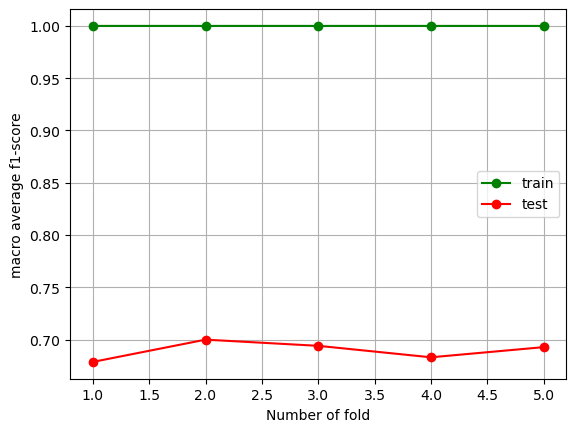

In [46]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='green', label='train')
plt.plot(folds, performance_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [47]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.69      0.71      0.70      1582
   B02 Blister and Insert Card       0.72      0.74      0.73      1749
          C01 - Folding carton       0.66      0.72      0.69      1644
                 C02 Trap Card       0.68      0.70      0.69       161
         C03 Trap Folding Card       0.71      0.67      0.69       438
            C04 Book packaging       0.83      0.50      0.62        20
               C05 Tray Packer       0.26      0.40      0.31        86
                  C06 Skincard       0.69      0.76      0.72       229
C07 Cardb. Sleeve w - w/o Shr.       0.50      0.37      0.42       135
C08 - Cardboard hanger w/o bag       0.40      0.46      0.43        80
        C09 - Paperboard pouch       0.69      0.59      0.63       696
  C10 - Carton cover (Lid box)       0.17      0.21      0.19       130
 C11 - Carton tube with or w/o       0.37      0.50      0.43  

### Deeper analysis of DecisionTreeClassifier

In [48]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,C01 - Folding carton,C08 - Cardboard hanger w/o bag,1.0
1,C01 - Folding carton,C01 - Folding carton,1.0
2,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0
3,B01 - Blister and sealed blist,C03 Trap Folding Card,1.0
4,C01 - Folding carton,C01 - Folding carton,1.0
5,C13 Envelope,C13 Envelope,1.0
6,B01 - Blister and sealed blist,B02 Blister and Insert Card,1.0
7,P03 Tube,P03 Tube,1.0
8,C07 Cardb. Sleeve w - w/o Shr.,C07 Cardb. Sleeve w - w/o Shr.,1.0
9,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0


In [49]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test
108,H1 Wooden box,H1 Wooden box,1.0
722,H1 Wooden box,P07 Plastic Box,1.0
848,H1 Wooden box,P03 Tube,1.0
1000,H1 Wooden box,H1 Wooden box,1.0
1450,H1 Wooden box,H1 Wooden box,1.0
2882,H1 Wooden box,H1 Wooden box,1.0
3708,H1 Wooden box,H1 Wooden box,1.0
3877,H1 Wooden box,P03 Tube,1.0
4105,H1 Wooden box,H1 Wooden box,1.0
4495,H1 Wooden box,H1 Wooden box,1.0


In [50]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)

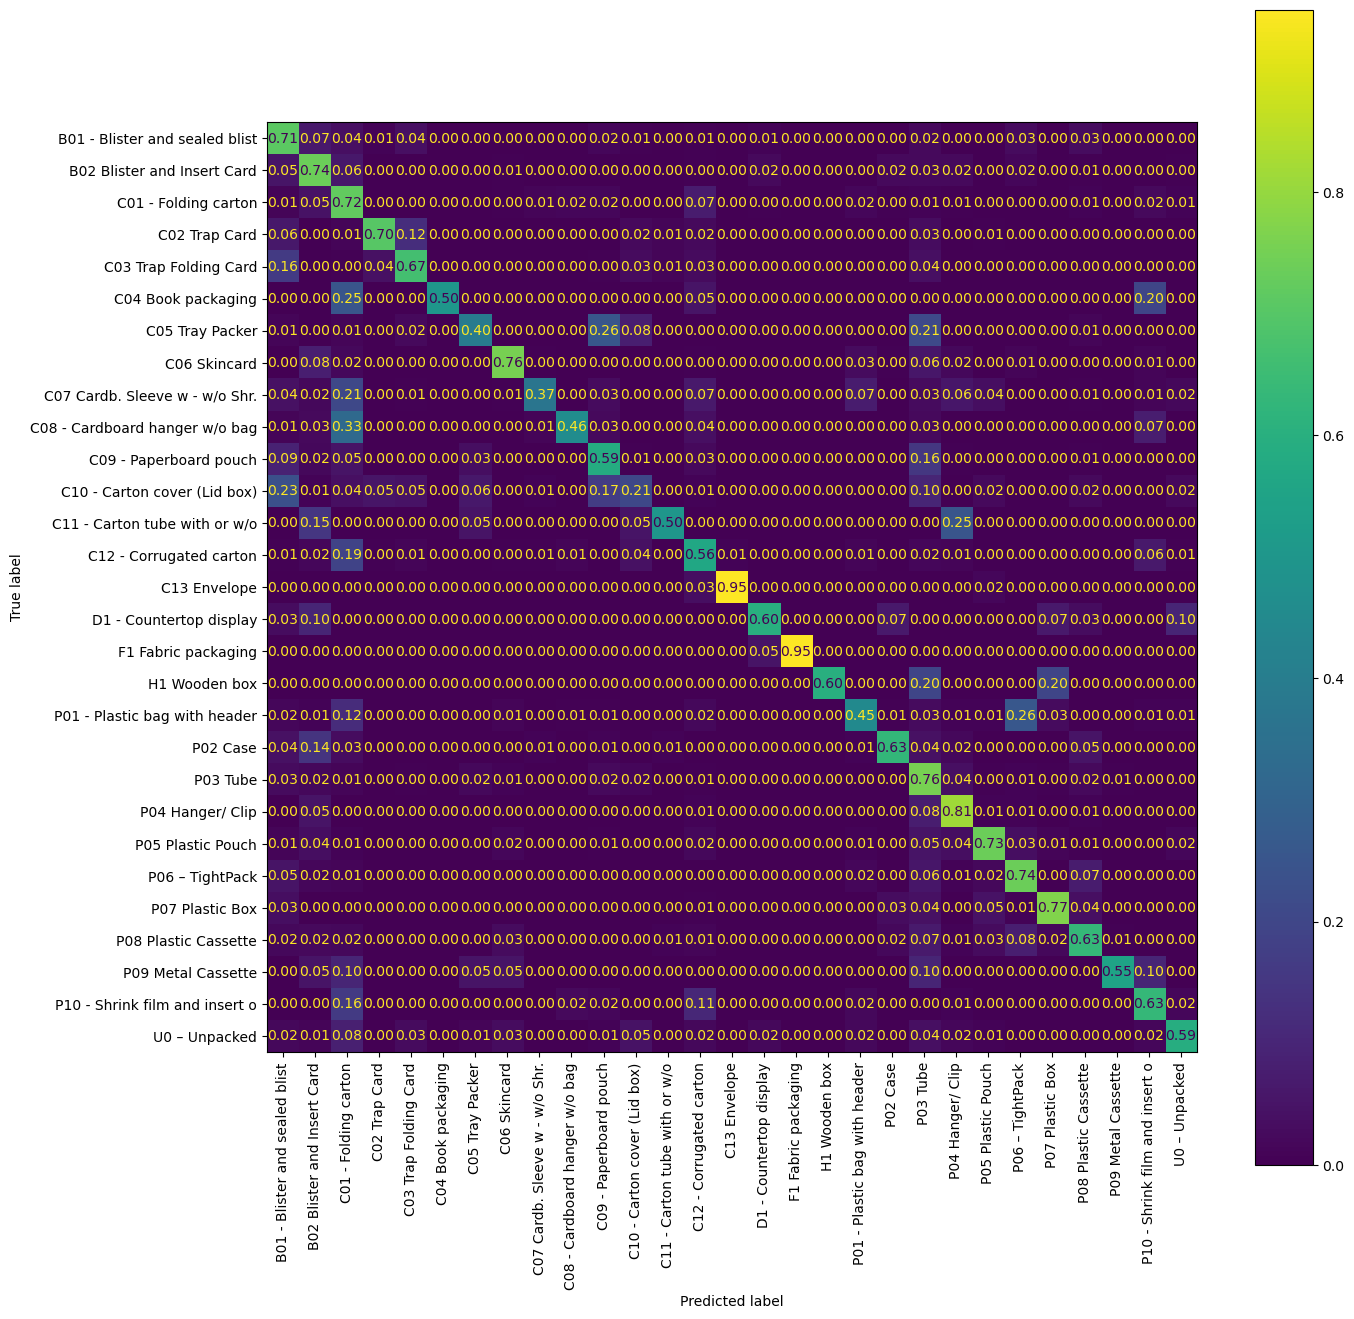

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

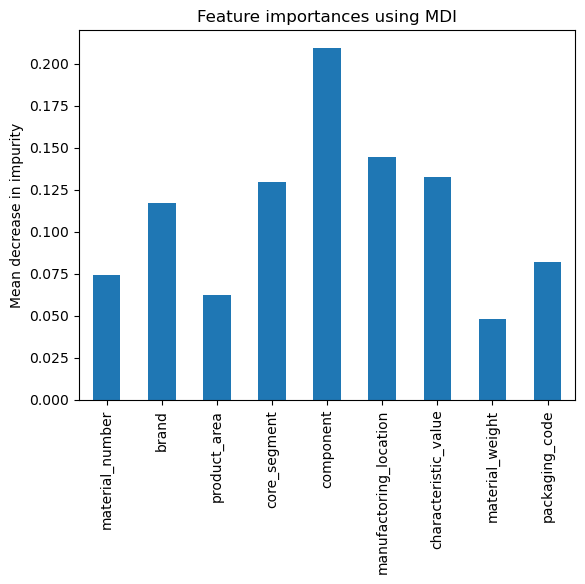

In [52]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Threshold analysis best model

Findings threshold analysis: since the decision tree does not provide probabilty a threshold analysis does not make any sense

In [53]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,C01 - Folding carton,C08 - Cardboard hanger w/o bag,1.0
1,C01 - Folding carton,C01 - Folding carton,1.0
2,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0
3,B01 - Blister and sealed blist,C03 Trap Folding Card,1.0
4,C01 - Folding carton,C01 - Folding carton,1.0
5,C13 Envelope,C13 Envelope,1.0
6,B01 - Blister and sealed blist,B02 Blister and Insert Card,1.0
7,P03 Tube,P03 Tube,1.0
8,C07 Cardb. Sleeve w - w/o Shr.,C07 Cardb. Sleeve w - w/o Shr.,1.0
9,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0


In [54]:
df_y_test_threshold = df_y_test.copy()
df_y_test_threshold.head()

,y_test,preds_y_test,proba_preds_y_test
0,C01 - Folding carton,C08 - Cardboard hanger w/o bag,1.0
1,C01 - Folding carton,C01 - Folding carton,1.0
2,B01 - Blister and sealed blist,B01 - Blister and sealed blist,1.0
3,B01 - Blister and sealed blist,C03 Trap Folding Card,1.0
4,C01 - Folding carton,C01 - Folding carton,1.0


In [55]:
# threshhold None

df_y_test_threshold_X = df_y_test_threshold

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.69      0.71      0.70      1582
   B02 Blister and Insert Card       0.72      0.74      0.73      1749
          C01 - Folding carton       0.66      0.72      0.69      1644
                 C02 Trap Card       0.68      0.70      0.69       161
         C03 Trap Folding Card       0.71      0.67      0.69       438
            C04 Book packaging       0.83      0.50      0.62        20
               C05 Tray Packer       0.26      0.40      0.31        86
                  C06 Skincard       0.69      0.76      0.72       229
C07 Cardb. Sleeve w - w/o Shr.       0.50      0.37      0.42       135
C08 - Cardboard hanger w/o bag       0.40      0.46      0.43        80
        C09 - Paperboard pouch       0.69      0.59      0.63       696
  C10 - Carton cover (Lid box)       0.17      0.21      0.19       130
 C11 - Carton tube with or w/o       0.37      0.50      0.43  

In [56]:
# threshhold 95
df_y_test_threshold_X = df_y_test_threshold.loc[
    df_y_test_threshold.proba_preds_y_test >= 0.95
]

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.69      0.71      0.70      1582
   B02 Blister and Insert Card       0.72      0.74      0.73      1749
          C01 - Folding carton       0.66      0.72      0.69      1642
                 C02 Trap Card       0.68      0.70      0.69       161
         C03 Trap Folding Card       0.71      0.67      0.69       438
            C04 Book packaging       0.83      0.50      0.62        20
               C05 Tray Packer       0.26      0.40      0.31        86
                  C06 Skincard       0.69      0.76      0.72       229
C07 Cardb. Sleeve w - w/o Shr.       0.50      0.37      0.42       135
C08 - Cardboard hanger w/o bag       0.40      0.46      0.43        80
        C09 - Paperboard pouch       0.69      0.59      0.63       696
  C10 - Carton cover (Lid box)       0.17      0.21      0.19       130
 C11 - Carton tube with or w/o       0.37      0.50      0.43  